In [1]:
# import dependencies
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
import numpy as np

In [2]:
# Loading data
# path may be different than mine
file_path = Path("../Resources/renamed_tornado_data.csv")
df = pd.read_csv(file_path)
print(df.shape)
df.head()

(67558, 14)


,Year,Month,Day,Date,State,Magnitude,Injuries,Fatalities,Start Lat,Start Long,Ending Lat,Ending Long,Length_in_Miles,Width_in_Yards
0,1950,1,3,1950-01-03,IL,3,3,0,39.10,-89.30,39.12,-89.23,3.6,130
1,1950,1,3,1950-01-03,MO,3,3,0,38.77,-90.22,38.83,-90.03,9.5,150
2,1950,1,3,1950-01-03,OH,1,1,0,40.88,-84.58,0.00,0.00,0.1,10
3,1950,1,13,1950-01-13,AR,3,1,1,34.40,-94.37,0.00,0.00,0.6,17
4,1950,1,25,1950-01-25,IL,2,0,0,41.17,-87.33,0.00,0.00,0.1,100


In [3]:
# Check types
df.dtypes

Year                 int64
Month                int64
Day                  int64
Date                object
State               object
Magnitude            int64
Injuries             int64
Fatalities           int64
Start Lat          float64
Start Long         float64
Ending Lat         float64
Ending Long        float64
Length_in_Miles    float64
Width_in_Yards       int64
dtype: object

In [4]:
# Look for null values
for column in df.columns:
    print(f"Column {column} has {df[column].isnull().sum()} null values")

Column Year has 0 null values
Column Month has 0 null values
Column Day has 0 null values
Column Date has 0 null values
Column State has 0 null values
Column Magnitude has 0 null values
Column Injuries has 0 null values
Column Fatalities has 0 null values
Column Start Lat has 0 null values
Column Start Long has 0 null values
Column Ending Lat has 0 null values
Column Ending Long has 0 null values
Column Length_in_Miles has 0 null values
Column Width_in_Yards has 0 null values


In [5]:
# look for duplicate rows
# Have fun playing with this. Tons and tons of duplicates! We will keep them all bc tornados happen everywhere all the time
print(f"Duplicate entries: {df[('Year')].duplicated().sum()}")

Duplicate entries: 67486


In [6]:
# Create Year total df to be recalled later
count_df=pd.DataFrame(df.Year.value_counts(ascending=True).sort_index().reset_index())
count_df.columns=['Year','Count']
count_df.head()

,Year,Count
0,1950,201
1,1951,260
2,1952,240
3,1953,421
4,1954,550


In [7]:
# drop columns if needed
# the date column is redundant because of the Year, Month, and Day columns
# state is considered redundant because of the lat and lon
df.drop(columns =["Year","Month","Day","Date", "State"], inplace=True)
df.head()

,Magnitude,Injuries,Fatalities,Start Lat,Start Long,Ending Lat,Ending Long,Length_in_Miles,Width_in_Yards
0,3,3,0,39.10,-89.30,39.12,-89.23,3.6,130
1,3,3,0,38.77,-90.22,38.83,-90.03,9.5,150
2,1,1,0,40.88,-84.58,0.00,0.00,0.1,10
3,3,1,1,34.40,-94.37,0.00,0.00,0.6,17
4,2,0,0,41.17,-87.33,0.00,0.00,0.1,100


In [8]:
df.describe()

,Magnitude,Injuries,Fatalities,Start Lat,Start Long,Ending Lat,Ending Long,Length_in_Miles,Width_in_Yards
count,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000
mean,0.691273,1.437876,0.090470,37.142412,-92.784618,22.730695,-56.245590,3.478340,106.577030
std,1.283375,18.263956,1.484106,5.093979,8.689103,18.588638,45.489157,8.278775,205.802676
min,-9.000000,0.000000,0.000000,17.721200,-163.530000,0.000000,-163.530000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,33.220000,-98.450000,0.000000,-94.709800,0.100000,20.000000
50%,1.000000,0.000000,0.000000,37.030000,-93.600000,32.480000,-84.420000,0.800000,50.000000
75%,1.000000,0.000000,0.000000,40.930000,-86.730000,38.610000,0.000000,3.130000,100.000000
max,5.000000,1740.000000,158.000000,61.020000,-64.715100,61.020000,0.000000,234.700000,4576.000000


In [9]:
# look for unique values
df.nunique()

Magnitude              7
Injuries             209
Fatalities            50
Start Lat          14215
Start Long         16024
Ending Lat         15043
Ending Long        16571
Length_in_Miles     2429
Width_in_Yards       405
dtype: int64

In [10]:
# check Magnitude values becasue of the 7 different values
count_mag=df.Magnitude.value_counts()
count_mag

 0    31375
 1    22885
 2     9517
 3     2536
-9      605
 4      581
 5       59
Name: Magnitude, dtype: int64

In [11]:
# According to the Dataset Creator "A mag of -9 means unknown rating".
# These rows also have 0 injuries and 0 fatalities. 
# We made the decisoin to remove these rows.
tornado_df = df.loc[df['Magnitude'] != -9]
print(tornado_df.shape)

(66953, 9)


<AxesSubplot:>

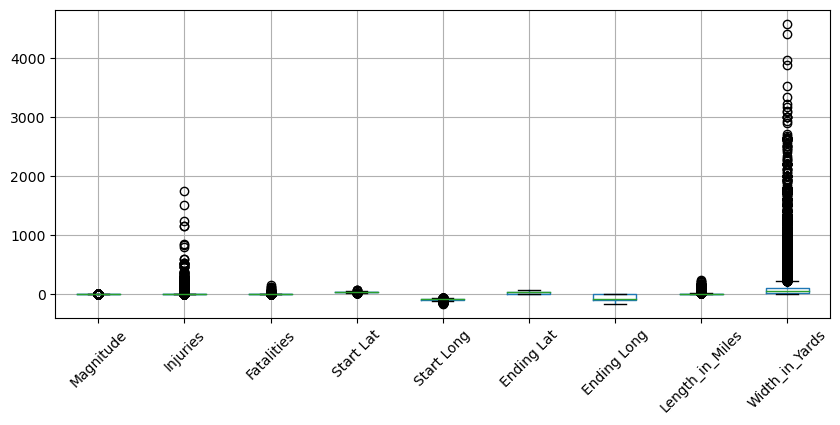

In [12]:
# quick boxplot to check for outliers
boxplot = tornado_df.boxplot(figsize = (10,4),rot=45)
boxplot

In [13]:
wid=df['Width_in_Yards'].value_counts()
wid[:50]

10      14291
50       9985
100      6785
30       4685
20       4230
200      2785
25       2279
150      1973
40       1916
75       1782
300      1341
33       1157
17       1035
400       896
23        812
250       702
60        700
440       670
500       593
80        542
13        517
0         473
70        460
880       440
73        436
27        435
67        350
77        264
350       248
15        246
600       237
125       225
800       225
220       182
120       149
110       138
90        137
700       134
35        123
1000      119
1760      109
175        94
450        91
1320       90
900        88
167        78
5          71
133        67
83         66
37         64
Name: Width_in_Yards, dtype: int64

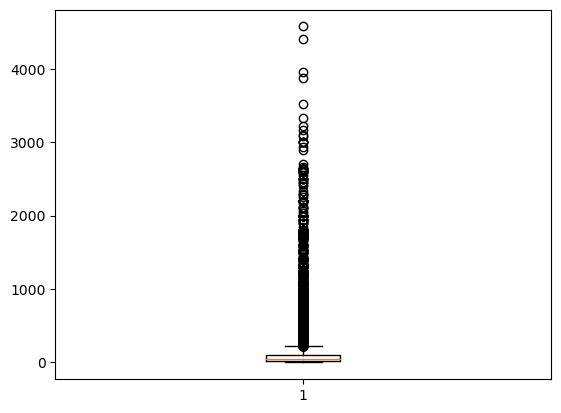

In [14]:
# Take a better look at Width in yards
plt.boxplot(tornado_df['Width_in_Yards'])
plt.show()

In [15]:
# removing Width_in_Yards. The 3rd quartile is 100. Seems like the entire column is an outlier 
tornado_df.drop(columns =["Width_in_Yards"], inplace=True)
tornado_df.head()

C:\Users\matth\anaconda3\envs\mlenv\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Magnitude,Injuries,Fatalities,Start Lat,Start Long,Ending Lat,Ending Long,Length_in_Miles
0,3,3,0,39.10,-89.30,39.12,-89.23,3.6
1,3,3,0,38.77,-90.22,38.83,-90.03,9.5
2,1,1,0,40.88,-84.58,0.00,0.00,0.1
3,3,1,1,34.40,-94.37,0.00,0.00,0.6
4,2,0,0,41.17,-87.33,0.00,0.00,0.1


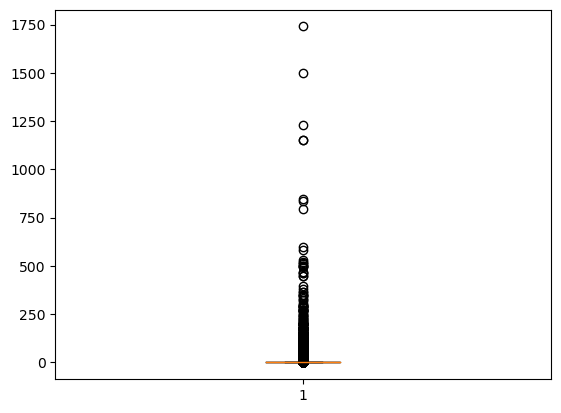

In [16]:
# Check Injuries for outliers
plt.boxplot(tornado_df.Injuries)
plt.show()

In [17]:
# remove the outliers. 750 and higher
tornado_df = tornado_df[tornado_df.Injuries < 750]
print(tornado_df.shape)

(66945, 8)


In [18]:
# Create target(y) and features(X) arrays
y = tornado_df["Injuries"].values
X = tornado_df.drop(["Injuries"],1).values

C:\Users\matth\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
# Split into our training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=44)

In [20]:
# create scaler, fit, transform training and testing sets
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# RANDOM FOREST MODEL

In [21]:
# create model
rfr_model = RandomForestRegressor(n_estimators=110, random_state=1)

In [22]:
# Fit model
rfr_model = rfr_model.fit(X_train_scaled, y_train)

In [23]:
# Evaluate model
pred = rfr_model.predict(X_test_scaled)
# print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")
print(pred)

[0.         0.11818182 0.14545455 ... 0.         0.         1.11818182]


In [24]:
# Define the model
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 48
hidden_nodes_layer2 = 36
hidden_nodes_layer3 = 24
hidden_nodes_layer4 = 12
hidden_nodes_layer5 = 10
hidden_nodes_layer6 = 8

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="tanh"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="tanh"))

# Fourth hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer4, activation="relu"))

# Fifth hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer5, activation="tanh"))

# sixth hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer6, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile model
nn.compile(loss="mean_absolute_error", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=50)

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
1569/1569 [==============================] - 4s 2ms/step - loss: 1.3154 - accuracy: 0.8750
Epoch 2/50
1569/1569 [==============================] - 2s 2ms/step - loss: 1.3026 - accuracy: 0.8797
Epoch 3/50
1569/1569 [==============================] - 2s 1ms/step - loss: 1.3030 - accuracy: 0.8730
Epoch 4/50
1569/1569 [==============================] - 2s 2ms/step - loss: 1.3031 - accuracy: 0.8740
Epoch 5/50
1569/1569 [==============================] - 2s 2ms/step - loss: 1.3019 - accuracy: 0.8765
Epoch 6/50
1569/1569 [==============================] - 2s 2ms/step - loss: 1.3017 - accuracy: 0.8800
Epoch 7/50
1569/1569 [==============================] - 3s 2ms/step - loss: 1.2992 - accuracy: 0.8783
Epoch 8/50
1569/1569 [==============================] - 2s 2ms/step - loss: 1.2998 - accuracy: 0.8748
Epoch 9/50
1569/1569 [==============================] - 2s 1ms/step - loss: 1.3029 - accuracy: 0.8751
Epoch 10/50
1569/1569 [==============================] - 3s 2ms/step - loss: 1.301

#### Not enough Data here to use a neural network. NO real change in loss or accuracy.

# MULTILE LINEAR REGRESSION MODEL

In [25]:
# Train the model
mlr = LinearRegression()
mlr.fit(X_train, y_train)

LinearRegression()

In [26]:
# check coeffecients
mlr.coef_

array([ 1.24020679e+00,  7.42346983e+00, -1.81085998e-02,  3.58069715e-03,
        3.68935323e-02,  1.57696320e-02,  1.29912019e-01])

In [27]:
# find intercept
mlr.intercept_

0.33172418025714645

In [28]:
# test training model
y_pred = mlr.predict(X_test)
print(y_pred)

[ 0.7754462   1.29144104  1.31321975 ... -0.62886136 -0.57654801
  2.5153468 ]


In [29]:
# Predict against known value of row 1
mlr.predict([[3,0,39.10,-89.30,39.12,-89.23,3.6]])
# dataset is 3, predict model is 3.52

array([3.52837603])

In [30]:
# look up mean error and squared
print(metrics.r2_score(y_test,y_pred))
print(mean_squared_error(y_test,y_pred))
print(mean_absolute_error(y_test,y_pred))

0.5451963968361878
78.00997856937092
1.83677817464087


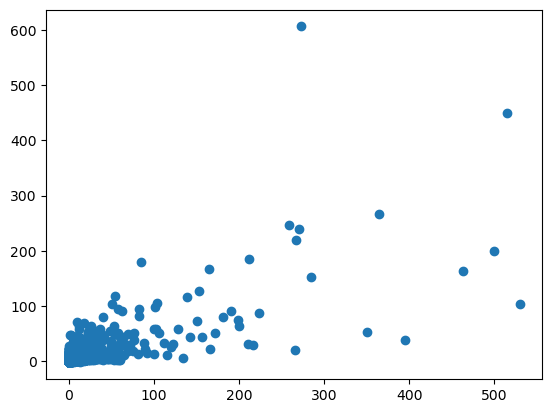

In [31]:
plt.scatter(y_test, y_pred)
plt.show()

In [32]:
pred_df = pd.DataFrame({'Actual_Injuries': y_test, 'Predicted_injuries': y_pred, 'Difference': y_test-y_pred})
pred_df.head(20)

,Actual_Injuries,Predicted_injuries,Difference
0,0,0.775446,-0.775446
1,0,1.291441,-1.291441
2,0,1.313220,-1.313220
3,0,0.727405,-0.727405
4,0,2.644600,-2.644600
5,0,1.082105,-1.082105
6,2,0.620198,1.379802
7,0,2.360179,-2.360179
8,0,-0.711849,0.711849
9,0,0.853617,-0.853617


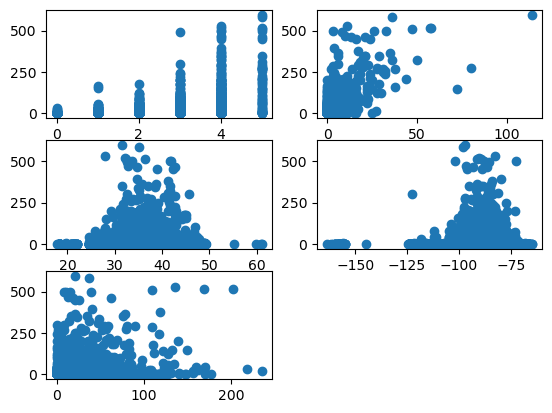

In [33]:
# PLot all features against y to see if any features do not lend themselves to a linear regresssion model
plt.subplot(3,2,1)
plt.scatter(tornado_df['Magnitude'],tornado_df['Injuries'])
plt.subplot(3,2,2)
plt.scatter(tornado_df['Fatalities'],tornado_df['Injuries'])
plt.subplot(3,2,3)
plt.scatter(tornado_df['Start Lat'],tornado_df['Injuries'])
plt.subplot(3,2,4)
plt.scatter(tornado_df['Start Long'],tornado_df['Injuries'])
plt.subplot(3,2,5)
plt.scatter(tornado_df['Length_in_Miles'],tornado_df['Injuries'])
plt.show()

# LINEAR REGRESSION

In [34]:
# Recall count_df
count_df.head()

,Year,Count
0,1950,201
1,1951,260
2,1952,240
3,1953,421
4,1954,550


In [35]:
# Assign x and y values (a,b) respectively.
a=count_df.Year.values.reshape(-1,1)
b=count_df.Count

In [36]:
# Create Model
lr = LinearRegression()

In [37]:
# Train model
lr.fit(a,b)

LinearRegression()

In [38]:
lr.coef_

array([12.69046241])

In [39]:
lr.intercept_

-24258.607557827945

In [40]:
b_pred = lr.predict(a)
print(b_pred)

[ 487.79414003  500.48460244  513.17506485  525.86552726  538.55598967
  551.24645208  563.93691449  576.62737689  589.3178393   602.00830171
  614.69876412  627.38922653  640.07968894  652.77015135  665.46061376
  678.15107617  690.84153858  703.53200099  716.2224634   728.9129258
  741.60338821  754.29385062  766.98431303  779.67477544  792.36523785
  805.05570026  817.74616267  830.43662508  843.12708749  855.8175499
  868.50801231  881.19847471  893.88893712  906.57939953  919.26986194
  931.96032435  944.65078676  957.34124917  970.03171158  982.72217399
  995.4126364  1008.10309881 1020.79356122 1033.48402362 1046.17448603
 1058.86494844 1071.55541085 1084.24587326 1096.93633567 1109.62679808
 1122.31726049 1135.0077229  1147.69818531 1160.38864772 1173.07911012
 1185.76957253 1198.46003494 1211.15049735 1223.84095976 1236.53142217
 1249.22188458 1261.91234699 1274.6028094  1287.29327181 1299.98373422
 1312.67419663 1325.36465903 1338.05512144 1350.74558385 1363.43604626
 1376.12

In [41]:
# Predict future year
lr.predict([[2050]])

array([1756.84038095])

In [42]:
# Check accuracy based on data
print(metrics.r2_score(b,b_pred))

0.6261508174496611


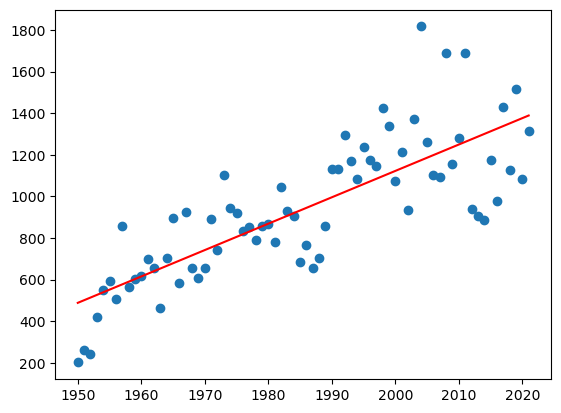

In [43]:
# plot  the count_df
plt.scatter(a, b)
plt.plot(a, b_pred, color='red')
plt.show()

In [44]:
# Check predictions on the first 20 rows
count_pred_df = pd.DataFrame({'Actual_Count': b, 'Predicted_Count':b_pred, 'Difference': b-b_pred})
count_pred_df.head(20)

,Actual_Count,Predicted_Count,Difference
0,201,487.794140,-286.794140
1,260,500.484602,-240.484602
2,240,513.175065,-273.175065
3,421,525.865527,-104.865527
4,550,538.555990,11.444010
5,591,551.246452,39.753548
6,504,563.936914,-59.936914
7,858,576.627377,281.372623
8,564,589.317839,-25.317839
9,604,602.008302,1.991698


## Model predicts an increase of approx 12.69 tornados per year